In [1]:
# Refer to path of package
import sys
sys.path.append('/Users/watcharapongwongrattanasirikul/Documents/Git/Jupyter/my_env/lib/python3.8/site-packages')

In [2]:
# Import Lib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import re
from random import choices, randint, randrange, uniform

In [3]:
from ml_helper import MlHelper
from eda_helper import EdaHelper
from sampling_helper import SamplingHelper
from impute_helper import ImputeHelper
from impute_helper import imputation_strategy
from ml_helper import model_type
from ml_helper import resampler_type
from ml_helper import scaler_type
import cleansing_helper as CleansingHelper

In [4]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/train_timeseries.csv'

df = pd.read_csv(file_path)
df.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


In [5]:
df.drop(['RNF'], axis=1, inplace=True)
df.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0


In [6]:
# Rename of columns
df = df.rename(columns={
    'Air temperature [K]':'AirTemp',
    'Process temperature [K]':'ProcessTemp',
    'Rotational speed [rpm]':'RotationalSpeed',
    'Torque [Nm]':'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure':'MF'
})
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0


In [7]:
convert_type = {'H':1, 'M':2, 'L':3}

def mapping_type(item):
    if item in convert_type.keys():
      return convert_type[item]
    else:
      return -1

In [9]:
# encode type to be number

df['Type'] = df['Type'].apply(mapping_type)

In [10]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF
0,1,M14860,-1,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,-1,298.2,308.7,1408,46.3,3,0,0,0,0,0


### Feature Engineering

In [11]:
# The importance feature of power failure  is Power then we create the Power feature 
# Power(kW) = Torque (N.m) x Speed (rpm)

df['Power'] = df['Torque'] * df['RotationalSpeed']
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power
0,1,M14860,-1,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8
1,2,L47181,-1,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4


In [12]:
# The importance feature of heat dissipation failure  is temperature
df['AirDiff'] = df['ProcessTemp'] - df['AirTemp']
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
0,1,M14860,-1,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5
1,2,L47181,-1,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5


In [13]:
pd.set_option('display.max_columns', None)
df[(df['AirDiff'] <= 8.6) & (df['RotationalSpeed'] < 1380)].head(5)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
3236,3237,M18096,-1,300.8,309.4,1342,62.4,113,1,0,1,0,0,83740.8,8.6
3760,3761,L50940,-1,302.3,310.9,1377,46.8,166,1,0,1,0,0,64443.6,8.6
3787,3788,L50967,-1,302.3,310.8,1377,47.3,22,1,0,1,0,0,65132.1,8.5
3793,3794,L50973,-1,302.3,310.9,1379,49.3,34,1,0,1,0,0,67984.7,8.6
3806,3807,M18666,-1,302.3,310.9,1360,44.0,67,1,0,1,0,0,59840.0,8.6


### Function for check behavior

## Plot Feature

In [14]:
def get_moving_average(df, window_size=10):
    windows = df.rolling(window_size)
    moving_average = windows.mean()
    moving_averages_list = moving_average.tolist()
    final_list = moving_averages_list[window_size - 1:]
    
    return(final_list)

In [41]:
def plot_feature_class(df, feautures, label, window_size=10):
    fig, ax = plt.subplots(len(feautures)+1, 1, figsize=(10,5))
    sns.lineplot(ax=ax[1], x=range(df.shape[0]), y=label, data=df, alpha=0.5, color='black' )
    
    
    for idx, feature in enumerate(feautures):
        sns.lineplot(ax=ax[0], x=range(df.shape[0]), y=feautures[idx], data=df, alpha=0.5 )
#         sns.lineplot(ax=ax[idx+1], x=range(window_size-1, df.shape[0]), y=get_moving_average(df[feature], window_size), alpha=0.5 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )

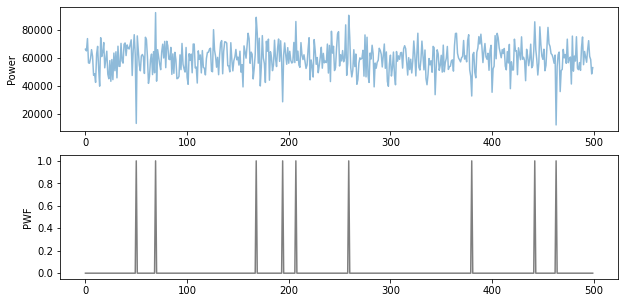

In [42]:
df_plot = df[0:500]
plot_feature_class(df_plot, ['Power'],'PWF')

# Genetic Algorithms to find the prediction pattern

## encoder function

In [16]:
# This function use to encode data point to be class label
# a = data less than or equal percentile 25
# b = data less than or equal percentile 50
# c = data less than or equal percentile 75
# d = data greater than percentile 75

def encode_feature(df, is_print_info=False):
    
    mean = np.mean(df)
    std = np.std(df)
    
    if is_print_info:
        print(f'mean: {mean}')
        print(f'std: {std}')
        print(f'a: {mean - (3*std)}')
        print(f'b: {mean - (2*std)}')
        print(f'c: {mean - (1*std)}')
        print(f'd: {mean}')
        print(f'e: {mean + (1*std)}')
        print(f'f: {mean + (2*std)}')
        print(f'g: {mean + (3*std)}')
    
    encoder_list = []
    
    for data_point in df:
        
        if is_print_info:
            print(data_point)
        
        if data_point <= (mean - (3*std)):
            encoder_list.append('a')
            continue
        
        if data_point <= (mean - (2*std)):
            encoder_list.append('b')
            continue
            
        if data_point <= (mean - (1*std)):
            encoder_list.append('c')
            continue
            
        if data_point <= mean:
            encoder_list.append('d')
            continue
            
        if data_point <= (mean + (1*std)):
            encoder_list.append('e')
            continue
            
        if data_point <= (mean + (2*std)):
            encoder_list.append('f')
            continue       
            
        if data_point <= (mean + (3*std)):
            encoder_list.append('g')
            continue   
                        
        encoder_list.append('h')

    return encoder_list

In [17]:
test_encoder = encode_feature(df['Torque'], False)
test_encoder[100:110]

['c', 'c', 'e', 'e', 'e', 'd', 'e', 'e', 'd', 'd']

### Generate the random genome by specific length

In [18]:
def generate_genome(genome_length:int=5, num_pattern:int=1):
    
    previous_gene = ''
    or_logic = False
    count_or = 0
    genome_group = []
    
    for j in range(num_pattern):
        
        genome = []
        for i in range(genome_length):

            # First character should not be symbol
            if i == 0:
                next_gene = choices(['a','b','c','d','e','f','g','h'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                continue

            # Last character should not be symbol
            if i == (genome_length-1):
                next_gene = choices(['a','b','c','d','e','f','g','h'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                continue

            # If previous character is symbol then next character should not be symbol
            if previous_gene[0] == '.*' or previous_gene[0] == '|':
                next_gene = choices(['a','b','c','d','e','f','g','h'], k=1)
                genome = genome + next_gene

                if previous_gene[0] == '|':
                    or_logic = True
                    count_or = 2

                previous_gene = next_gene
                continue

            if count_or > 0:
                next_gene = choices(['a','b','c','d','e','f','g','h'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                count_or = count_or - 1
                continue

            next_gene = choices(['a','b','c','d','e','f','g','h','.*','|'], k=1)            
            genome = genome + next_gene
            previous_gene = next_gene
        genome_group.append(genome) 
    
    return genome_group

In [19]:
test_genome = generate_genome(genome_length=5, num_pattern=2)
test_genome

[['a', 'c', '.*', 'a', 'e'], ['f', 'h', 'g', 'c', 'c']]

### Generate the population

In [20]:
def generate_population(size, genome_lenght, num_pattern=1, num_feature=1):
    return [generate_genome(genome_lenght, num_pattern) for _ in range(size)]

In [21]:
test_population = generate_population(size=10, genome_lenght=5, num_pattern=2)
for genome in test_population:
    print(genome)

[['a', 'b', 'h', 'f', 'c'], ['b', 'c', 'g', '|', 'f']]
[['b', '|', 'h', 'e', 'f'], ['f', 'g', 'd', '|', 'g']]
[['a', 'd', 'a', 'e', 'd'], ['e', 'b', 'c', 'a', 'h']]
[['e', 'h', 'b', 'h', 'f'], ['f', '|', 'e', 'h', 'h']]
[['g', '|', 'c', 'h', 'f'], ['b', 'b', 'd', '.*', 'd']]
[['c', 'c', 'a', 'h', 'a'], ['d', 'g', 'e', 'g', 'b']]
[['e', 'f', 'a', 'f', 'h'], ['e', 'h', 'f', 'g', 'd']]
[['f', 'f', '.*', 'a', 'e'], ['b', 'g', 'h', 'd', 'd']]
[['a', 'a', 'f', 'g', 'c'], ['c', 'a', 'b', 'd', 'f']]
[['e', '|', 'a', 'b', 'a'], ['d', 'f', 'd', 'c', 'c']]


### Get expression

In [23]:
def get_expression(data, num_pattern):
    
    or_flag = False
    expression_group = []
    
    for j in range(num_pattern):
        reg_result = ""
        
        for idx, i in enumerate(data[j]):

            if i == '|' and reg_result == "":
                raise Exception(f"The symbol '|' can't be the first parameter: {data}")

            if i == '|' and (idx + 1) == len(data[j]):
                raise Exception(f"The symbol '|' can't be the last parameter: {data}")

            if i in ('a', 'b', 'c', 'd','e','f','g','h','.*') and or_flag == False:
                reg_result = reg_result + i
                buf = i
                continue

            if i in ('a', 'b', 'c', 'd','e','f','g','h','.*') and or_flag == True:
                reg_result = reg_result + f"{i}]"
                or_flag = False
                continue

            if or_flag == True and (i == '|' or i == '.*'):
                reg_result = reg_result + 'd'
                continue

            if i == '|':
                reg_result = reg_result[0:(len(reg_result)- len(buf))]
                reg_result = reg_result + f"[{buf}|"
                or_flag = True
                continue
                
        expression_group.append('.*'+reg_result+".*")
 
    return expression_group

In [24]:
test_genome

[['a', 'c', '.*', 'a', 'e'], ['f', 'h', 'g', 'c', 'c']]

In [25]:
test_expression = get_expression(test_genome, num_pattern=2)

print(test_expression)

['.*ac.*ae.*', '.*fhgcc.*']


### Encoded feature fortesting

In [26]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5


In [27]:
df_MF = df['MF']
df_TWF = df['TWF']
df_HDF = df['HDF']
df_PWF = df['PWF']
df_OSF = df['OSF']

df_torque = df['Torque']
df_speed = df['RotationalSpeed']
df_airtemp = df['AirTemp']
df_processtemp = df['ProcessTemp']
df_toolwear = df['ToolWear']
df_power = df['Power']
df_airdiff = df['AirDiff']

encoded_torque = encode_feature(df_torque)
encoded_speed = encode_feature(df_speed)
encoded_airtemp = encode_feature(df_airtemp)
encoded_processtemp = encode_feature(df_processtemp)
encoded_toolwear = encode_feature(df_toolwear)
encoded_power = encode_feature(df_power)
encoded_airdiff = encode_feature(df_airdiff)

### Calculate the fitness score

In [28]:
def fitness(genome, encoded_feature, df, window_size=20, is_print_info = False, num_pattern=1):
    
    if is_print_info:
        print(f'Input genome: {genome}')
    
    # Initial setting for window
    start = 0
    end = window_size
    number_round = int(len(encoded_feature)/window_size)-1
    
    if is_print_info:
        print(f'Number of round: {int(number_round)}')
    
    fitness_score = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Get reg function from genome
    reg_expression = get_expression(genome, num_pattern)
    
    if is_print_info:
        print(f'genome---: {genome}')
        print(f'reg---: {reg_expression[0]}')
    
    predict_list = []
    
    # Iterate over the data by specific period
    for i in range(number_round):
        
        if is_print_info:
            print(f'round: {i}')
        
        # Start by predict the next window doesn't has failed
        predict_fail = False 

        # Get current pattern of feature by window size
        current_pattern = ''.join(encoded_feature[start:end])

        # Check regular matched
        for reg_pattern in reg_expression:
            
            if predict_fail == True:
                pass
            else:
                matched = re.search(reg_pattern, current_pattern)
            
                if matched is not None:
                    predict_fail = True
                else:
                    predict_fail = False


        # Find the next period will have the fail case or not
        fail_next_period = list(df[end:end+window_size])
        is_fail_next_period = sum(fail_next_period)>0
    
        # Calculate Fitness Score
        if  predict_fail == True and is_fail_next_period == True:
            TP += 1
            
        if predict_fail == True and is_fail_next_period == False:
            FP += 1
            
        if predict_fail == False and is_fail_next_period == False:
            TN += 1
            
        if predict_fail == False and is_fail_next_period == True:
            FN += 1

        start += window_size
        end += window_size
        
    # Calculate accuracy
    if (TN + FP + TP + FN) == 0:
        accuracy = 0
    else:
        accuracy = (TN + TP)/(TN + FP + TP + FN)
        
    # Calculate recall    
    if (TP+FN) == 0:
        recall = 0
    else:
        recall = TP/(TP + FN)
    
    # Calculate precision
    if (TP+FP) == 0:
        precision = 0
    else:
        precision = TP/(TP+FP)
    
    # Calculate f1 score
    if (precision+recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * ((precision * recall)/(precision+recall))
    
    return(f1_score, accuracy, precision, recall)

In [29]:
# Mock data for test data with 2 patterns

genome_mock = [['c', '|', 'f', 'f', 'e'], ['h', 'd', 'd', 'g', 'f']]
encode_feature_mock = 'aaacffeaaaaaaaaaaaaaaaaaaaaaahddgfaaaaaaaaaaaaaaaaaaaaaaaaaa'
df_mock = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]

In [30]:
fitness(genome_mock, encode_feature_mock, df_mock, window_size=20, is_print_info = True, num_pattern=2)

Input genome: [['c', '|', 'f', 'f', 'e'], ['h', 'd', 'd', 'g', 'f']]
Number of round: 2
genome---: [['c', '|', 'f', 'f', 'e'], ['h', 'd', 'd', 'g', 'f']]
reg---: .*[c|f]fe.*
round: 0
round: 1


(1.0, 1.0, 1.0, 1.0)

In [31]:
# Mock data for test data with 1 patterns

genome_mock = [['c', '|', 'f', 'f', 'e']]
encode_feature_mock = 'aaacffeaaaaaaaaaaaaaaaaaaaaaahddgfaaaaaaaaaaaaaaaaaaaaaaaaaa'
df_mock = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]

In [32]:
fitness(genome_mock, encode_feature_mock, df_mock, window_size=20, is_print_info = True, num_pattern=1)

Input genome: [['c', '|', 'f', 'f', 'e']]
Number of round: 2
genome---: [['c', '|', 'f', 'f', 'e']]
reg---: .*[c|f]fe.*
round: 0
round: 1


(0.6666666666666666, 0.5, 1.0, 0.5)

### Selection Pair

In [33]:
def selection_pair(population, weights, number=10):
    return choices(
        population=population,
        weights= weights,
        k=number
    )

In [34]:
test_population

[[['a', 'b', 'h', 'f', 'c'], ['b', 'c', 'g', '|', 'f']],
 [['b', '|', 'h', 'e', 'f'], ['f', 'g', 'd', '|', 'g']],
 [['a', 'd', 'a', 'e', 'd'], ['e', 'b', 'c', 'a', 'h']],
 [['e', 'h', 'b', 'h', 'f'], ['f', '|', 'e', 'h', 'h']],
 [['g', '|', 'c', 'h', 'f'], ['b', 'b', 'd', '.*', 'd']],
 [['c', 'c', 'a', 'h', 'a'], ['d', 'g', 'e', 'g', 'b']],
 [['e', 'f', 'a', 'f', 'h'], ['e', 'h', 'f', 'g', 'd']],
 [['f', 'f', '.*', 'a', 'e'], ['b', 'g', 'h', 'd', 'd']],
 [['a', 'a', 'f', 'g', 'c'], ['c', 'a', 'b', 'd', 'f']],
 [['e', '|', 'a', 'b', 'a'], ['d', 'f', 'd', 'c', 'c']]]

In [35]:
weights = [0.8, 0.2, 0, 0, 0, 0, 0, 0, 0, 0]
selected_genome = selection_pair(test_population, weights, number=5)
selected_genome

[[['a', 'b', 'h', 'f', 'c'], ['b', 'c', 'g', '|', 'f']],
 [['a', 'b', 'h', 'f', 'c'], ['b', 'c', 'g', '|', 'f']],
 [['b', '|', 'h', 'e', 'f'], ['f', 'g', 'd', '|', 'g']],
 [['a', 'b', 'h', 'f', 'c'], ['b', 'c', 'g', '|', 'f']],
 [['a', 'b', 'h', 'f', 'c'], ['b', 'c', 'g', '|', 'f']]]

### Cross Over

In [36]:
def single_point_cross_over(genome1, genome2, num_pattern=1):
    
    is_print_info = False
    
    if is_print_info:
        print(f'This is genome1: {genome1}')
        print(f'This is genome2: {genome2}')
    
    genome_result1 = []
    genome_result2 = []

    
    for i in range(num_pattern):
        if len(genome1[i]) != len(genome2[i]):
            print(genome1[i])
            print(genome2[i])
            raise ValueError("Genomes 1 and 2 must be of same length")

        length = len(genome1[i])

        if length < 2:
            offspring1 = genome1[i]
            offspring2 = genome2[i]

        if length >= 2:    
            position = randint(1, length-1)
            offspring1 = genome1[i][0:position] + genome2[i][position:]
            offspring2 = genome2[i][0:position] + genome1[i][position:]
        
        genome_result1.append(offspring1)
        genome_result2.append(offspring2)
        
        
    if is_print_info:
        print('after')
        print(f'This is genome1: {genome_result1}')
        print(f'This is genome2: {genome_result2}')
        print('*'*30)
    
    return genome_result1, genome_result2

In [37]:
test_genome1 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10], [11,12,13,14,15]]
test_genome2 = [[15,14,13,12,11],[10, 9 , 8, 7, 6], [5, 4, 3, 2, 1]]

print(single_point_cross_over(test_genome1, test_genome2, num_pattern=3))

([[1, 14, 13, 12, 11], [6, 7, 8, 9, 6], [11, 4, 3, 2, 1]], [[15, 2, 3, 4, 5], [10, 9, 8, 7, 10], [5, 12, 13, 14, 15]])


In [38]:
test_genome1 = [[1, 2, 3, 4 ,5]]
test_genome2 = [[15, 14, 13, 12, 11]]
print(single_point_cross_over(test_genome1, test_genome2, num_pattern=1))

([[1, 14, 13, 12, 11]], [[15, 2, 3, 4, 5]])


### Mutation

In [39]:
def mutation(genome, number=1, num_pattern=1):
    for i in range(num_pattern):
        for _ in range(number):
            index = randrange(len(genome[i]))
            genome[i][index] = choices(['a','b','c','d','e','f','g'], k=1)[0]

    return genome

In [40]:
test_genome3 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10]]
new = mutation(test_genome3, num_pattern=2)
new

[[1, 2, 3, 4, 'e'], [6, 7, 'e', 9, 10]]

In [41]:
test_genome4 = [[1, 2, 3, 4 ,5]]
new = mutation(test_genome4, num_pattern=1)
new

[[1, 2, 3, 4, 'e']]

### Evolution

In [42]:
def run_evolution(encoded_feature, df ,window_size, generation_limit=100, population_size=10, genome_length=10, num_pattern=1, is_print_log=False):
    
    best_ever_max_score = 0
    best_ever_pattern = []
    
    # Parameter setting
    pop_crossover_threshold = 0.80
    pop_mutation_threshold = 0.02
    
    # --------------------------------------- 1. Generate Population --------------------------------------- #
    population = generate_population(size=population_size, genome_lenght=genome_length, num_pattern=num_pattern)
    
    if is_print_log:
        print(f'first population {population}')
    
    for i in range(generation_limit):
        
        # 1. Calculate fitness score for all population
        # f1_score:0, accuracy:1, precision:2, recall:3
        fitness_scores = [fitness(genome, encoded_feature, df=df, window_size=window_size, is_print_info=False, num_pattern=num_pattern)[0] for genome in population]

        max_score = max(fitness_scores)
        
        if max_score > best_ever_max_score:
            best_ever_max_score = max_score
            
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            best_ever_pattern = population_and_score[0][1]
                
        if is_print_log:
            print(f'round {i} has max score {max_score}.')  #The whole score list {fitness_scores}')
            
        if is_print_log and False:   
            print('*'*50)
            population_and_score = list(zip(fitness_scores, population))
            print(f'population and score: {population_and_score}')
            print('*'*50)

        # 2. Evaluation
        if max_score >= 0.8:
            population_and_score = list(zip(fitness_scores, population))
            sorted_population_and_score = population_and_score.sort(reverse=True)
            top_population = sorted_population_and_score[0]
            print(f"The best population is {top_population[1]} with score {top_population[0]}")
            break

        # 3. Select new population
        if sum(fitness_scores) == 0:
            adjust_score = [1 for i in fitness_scores]
            weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
            new_population = selection_pair(population, weight_selection, population_size)
            
        else:
            adjust_score = [i for i in fitness_scores]
            weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
            new_population = selection_pair(population, weight_selection, population_size)
            
            if is_print_log and False:   
                print('*'*50)
                print(f'new population: {new_population}')
                print('*'*50)

        # 4. Crossover
        offspring = []
        
        all_idx = list(range(len(new_population)))
        
        for idx, genome in enumerate(new_population):
            
            # Check index doesn't use yet
            if idx not in all_idx:
                continue
                
            # Remove the index of genome
            all_idx.remove(idx)
            
            # Get random index of other genome
            random_idx = choices(all_idx)[0]
            other_genome = new_population[random_idx]
            
            # Remove the index of other genome
            all_idx.remove(random_idx)
            
            # Check pop to cross over
            pop_crossover = uniform(0, 1)

            if pop_crossover <= pop_crossover_threshold:
                offspring1, offspring2 = single_point_cross_over(genome, other_genome, num_pattern=num_pattern)
            else:
                offspring1, offspring2 = genome, other_genome
                    
            offspring.append(offspring1)
            offspring.append(offspring2)

        new_population = offspring.copy()

        # 5. Mutation
        for idx, genome in enumerate(new_population):
            pop_mutation = uniform(0, 1)
            if pop_mutation <= pop_mutation_threshold: 
                
                is_show_mutation_log = False
                
                if is_show_mutation_log:  
                    print(f'Mutation !!!')
                    print(f'before: {new_population[idx]}')
                
                new_population[idx] = mutation(genome, num_pattern=num_pattern)
                
                if is_show_mutation_log:  
                    print(f'after: {new_population[idx]}')
        
        population = new_population
        
        # 6. Exist loop when exceed the generation_limit
        if i == generation_limit - 1:
            fitness_scores = [fitness(genome, encoded_feature, df=df, window_size=window_size, is_print_info=False, num_pattern=num_pattern)[0] for genome in population]
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            top_population = population_and_score[0]
            
            f1_score, accuracy, precision, recall = fitness(top_population[1], encoded_feature, df=df, window_size=window_size, num_pattern=num_pattern)
            #print(f"Last round the best population is {top_population[1]} with score {top_population[0]}")
            
    return(top_population, f1_score, accuracy, precision, recall, [best_ever_max_score, best_ever_pattern])
        

In [43]:
top_population, f1_score, accuracy, precision, recall, [best_ever_max_score, best_ever_pattern] = run_evolution(
    encoded_feature=encoded_power, 
    df=df_PWF,  
    window_size=25,
    generation_limit=10000,
    population_size=10,
    genome_length=6,
    num_pattern= 2,
    is_print_log=True
)

first population [[['g', '.*', 'd', 'h', 'h', 'f'], ['d', 'e', 'a', 'b', 'h', 'f']], [['c', 'd', '|', 'f', 'a', 'e'], ['e', 'c', 'c', 'b', 'h', 'b']], [['d', '.*', 'h', 'g', 'f', 'f'], ['c', 'c', 'g', 'g', '|', 'd']], [['a', 'g', '|', 'f', 'b', 'd'], ['b', 'e', 'c', 'f', 'b', 'g']], [['c', 'c', '|', 'f', 'f', 'd'], ['g', 'b', 'a', 'a', 'e', 'g']], [['h', '|', 'd', 'f', 'a', 'e'], ['h', 'g', 'd', 'f', 'h', 'b']], [['d', 'a', 'b', 'b', 'c', 'b'], ['g', '.*', 'a', 'f', 'e', 'e']], [['g', 'b', '.*', 'g', 'e', 'd'], ['e', 'f', 'f', 'd', 'a', 'a']], [['g', 'g', 'e', 'h', 'c', 'd'], ['h', 'c', '.*', 'h', 'd', 'd']], [['d', 'b', '|', 'a', 'g', 'd'], ['a', 'h', '.*', 'b', 'd', 'g']]]
round 0 has max score 0.06741573033707865.
round 1 has max score 0.06741573033707865.
round 2 has max score 0.06741573033707865.
round 3 has max score 0.06741573033707865.
round 4 has max score 0.06741573033707865.
round 5 has max score 0.06741573033707865.
round 6 has max score 0.06741573033707865.
round 7 has max

In [44]:
#top_population, f1_score, accuracy, precision, recall, [best_ever_max_score, best_ever_pattern] 
print(f'best_score: {best_ever_max_score}, best_ever_pattern:{best_ever_pattern}')

best_score: 0.33333333333333337, best_ever_pattern:[['e', 'c', '|', 'd', 'd', 'd'], ['g', 'c', 'f', 'g', 'f', 'b']]


### Test 1 Feature

In [97]:
def generate_report(max_pattern_length,window_sizes, encoded_feature, df, generation_limit, is_print_log):
    df_report = pd.DataFrame(columns = ['window_size','pattern_length','Pattern','F1','Accuracy','Precision','Recall'])
                           
    for genome_length in range(5,max_pattern_length+1):
        for window_size in window_sizes:

            if genome_length >= window_size:
                continue

            top_population, f1_score, accuracy, precision, recall, best_ever = run_evolution(
                    encoded_feature=encoded_feature, 
                    df=df,  
                    window_size=window_size,
                    generation_limit=generation_limit,
                    population_size=10,
                    genome_length=genome_length,
                    num_pattern=1,
                    is_print_log=is_print_log
                )

            data = [window_size,genome_length, top_population, f1_score, accuracy, precision, recall]

            try:
                df_report.loc[len(df_report)] = data
                print(f'complete for window_size {window_size}  and genome_length {genome_length}.')
            except Exception as e:
                print(f'error for window_size {window_size} and genome_length {genome_length}.')
                print('*'*50)
                print(e)
                print('*'*50)
                
    return df_report
                             
                             
    

In [94]:
df_report = generate_report(
        max_pattern_length=20,
        window_sizes=[15, 20, 25, 30], 
        encoded_feature=encoded_feature,
        df=df_PWF, 
        generation_limit=10, 
        is_print_log=False
)

complete for window_size 15  and genome_length 5.
complete for window_size 20  and genome_length 5.
complete for window_size 25  and genome_length 5.
complete for window_size 30  and genome_length 5.
complete for window_size 15  and genome_length 6.
complete for window_size 20  and genome_length 6.
complete for window_size 25  and genome_length 6.
complete for window_size 30  and genome_length 6.
complete for window_size 15  and genome_length 7.
complete for window_size 20  and genome_length 7.
complete for window_size 25  and genome_length 7.
complete for window_size 30  and genome_length 7.
complete for window_size 15  and genome_length 8.
complete for window_size 20  and genome_length 8.
complete for window_size 25  and genome_length 8.
complete for window_size 30  and genome_length 8.
complete for window_size 15  and genome_length 9.
complete for window_size 20  and genome_length 9.
complete for window_size 25  and genome_length 9.
complete for window_size 30  and genome_length 9.


In [95]:
df_report.sort_values(by=['F1'], ascending=False)

,window_size,pattern_length,Pattern,F1,Accuracy,Precision,Recall
2,25,5,"(0.37402597402597404, [[a, |, f, |, f]])",0.374026,0.244514,0.230032,1.000000
3,30,5,"(0.3658536585365854, [[a, |, e, e, c]])",0.365854,0.607547,0.326087,0.416667
7,30,6,"(0.3177570093457944, [[e, d, |, e, c, f]])",0.317757,0.724528,0.485714,0.236111
1,20,5,"(0.30997876857749473, [[d, |, |, e, d]])",0.309979,0.185464,0.184343,0.973333
0,15,5,"(0.19230769230769232, [[e, |, c, f, e]])",0.192308,0.684211,0.153846,0.256410
10,25,7,"(0.18032786885245902, [[c, |, g, b, |, f, e]])",0.180328,0.686520,0.220000,0.152778
5,20,6,"(0.16176470588235295, [[e, |, c, b, .*, d]])",0.161765,0.714286,0.180328,0.146667
11,30,7,"(0.09302325581395349, [[d, |, f, c, f, .*, g]])",0.093023,0.705660,0.285714,0.055556
14,25,8,"(0.07228915662650602, [[b, .*, e, d, |, h, c, ...",0.072289,0.758621,0.272727,0.041667
23,30,10,"(0.05333333333333333, [[f, a, |, c, .*, f, g, ...",0.053333,0.732075,0.666667,0.027778


### Generate Report

In [ ]:
test_features = [encoded_power]

result = generate_report(
    max_pattern_group=10,
    max_pattern_length=20,
    window_sizes= [5,  10,  15, 20],
    df_state=df_PWF,
    encoded_feautes=encoded_features,
    num_loop=5,
    print_log=False
)

In [ ]:
pd.set_option('display.max_rows', None)
result.sort_values(by=['F1'], ascending=False)

In [ ]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/result_PWF_(power)_1000.csv'
result.to_csv(file_path, index=None)

In [ ]:
.....bedc...... ---> Fail

In [ ]:
.....bedb......

In [ ]:
df_feature = df_scale['Tor-Rot']
feature_encoded = encode_feature(df_feature) 

In [ ]:
df_PWF = df['PWF']

In [ ]:
population = generate_population(10, 5)

score = run_evolution(population, encode_torque, df_PWF, 20000)

In [ ]:
a = ['A', 'B', 'C']
b = [3, 2, 1]

result = zip(b, a)
c =list(result)

In [ ]:
c

In [ ]:
c.sort(reverse=False)
c

In [ ]:
c[0][1]

In [ ]:
encode_torque

In [ ]:
for i in scores:
    print(type(i))

In [ ]:
weight = [i/sum(scores) for i in scores]
weight

In [ ]:
a1

In [ ]:
a2 = mutation(a1)

In [ ]:
a2

In [ ]:
a = generate_genome(10)
b = generate_genome(10)

In [ ]:
a1, b1 = single_point_cross_over(a, b)

In [ ]:
print(a)
print(b)
print(a1)
print(b1)

In [ ]:
fitness(test_genome, encode_torque, 'a')

In [ ]:
population_test = generate_population(10, 10)

In [ ]:
p = selection_pair(population_test, fitness)

In [ ]:
randint(1, 10)

In [ ]:
a = generate_genome(10)
a

In [ ]:
get_expression(a)

In [ ]:
# Test rolling windows

test_list = [1,2,3,4,5,7,8,9,10]

windows = pd.DataFrame(test_list).rolling(2)

for idx, i in enumerate(windows):
    print(list(i[0]))

In [ ]:
a = [1,2,3,4]

In [ ]:
weight = [i/sum(a) for i in a]

In [ ]:
weight